In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.optimize import minimize
from scipy.special import erf

from numpy import sqrt
from tqdm import tqdm 
import itertools
from numpy import cos 
from numpy import tan

# Making the uncertainty sphere 

The covariance matrix is constructed using AutoNav Data

In [14]:
covariance= np.array([[2677226.887245484, 285.21446641916737, 268.99258277423775, 0.4395130785408834, 0.04869538309075001, 0.04977713754424471], 
               [285.21446641916737, 0.9848154379616082, 0.9539977104619806, 5.143220640656547e-05, 2.402194457343449e-05, 1.1448019563650868e-05], 
               [268.99258277423775, 0.9539977104619806, 0.9362931818523705, 4.7953059657441394e-05, 2.0087537013333486e-05, 1.0905119663080185e-05], 
               [0.4395130785408834, 5.143220640656547e-05, 4.7953059657441394e-05, 9.116068280599878e-08, 9.657403280723735e-09, 9.569364053017187e-09], 
               [0.04869538309075001, 2.402194457343449e-05, 2.0087537013333486e-05, 9.657403280723735e-09, 2.632076219713602e-09, 1.587031182752267e-09], 
               [0.04977713754424471, 1.1448019563650868e-05, 1.0905119663080185e-05, 9.569364053017187e-09, 1.587031182752267e-09, 1.6117378623661833e-09]])

position_covariances= covariance[:3, :3] 
# since the covariance matrix is a 6x6 matrix for each state, position_covariances extracts a 3x3 
# matrix for the covariances relating the x, y, and z positions to each other 

# the radius in the x, y, and z directions of the uncertainty sphere is calculated using the means of each row of the position_covariances 
# matrix. Because the x positions are much larger than the y and z, the x radius was scaled by 1e-4 so it would be on the same magnitude as 
# the y and z radii

x_rad = np.mean(position_covariances[0]) * 1e-4
y_rad = np.mean(position_covariances[1])
z_rad = np.mean(position_covariances[2])

print(x_rad, y_rad, z_rad)

89.25936980982259 95.71775985586366 90.29429122218403


The field of view for rectilinear equations is: 
\begin{align} \text{FOV}  & = 2 \, \times \, \text{WD} \times \tan \left( \frac{ \text{AFOV} }{2} \right) \\ \end{align}


This information was obtained from: https://www.edmundoptics.com/knowledge-center/application-notes/imaging/understanding-focal-length-and-field-of-view

This is used in the information cost equation. In order to account for the orientation of the spacecraft with respect to the uncertainty sphere, an additional $\cos(\phi)$ term is added, making the new equation: 

\begin{align} \text{FOV}  & = 2 \, \times \, \text{WD} \times \tan \left( \frac{ \text{AFOV} }{2} \right) \times \cos(\phi) \\ \end{align}

Logically, we want to obtain the largest field of view of the ISO as we can get.

Now, to find the percent of the ISO ellipsoid that is viewed by the camera, we divide this field of view by volume of the ellipsoid, which is defined as: $$V= \frac{4}{3}\pi(x_{rad}y_{rad}z_{rad})$$
This formula was obtained from https://en.wikipedia.org/wiki/Ellipsoid

This then becomes $$\text{percent viewed} = 2 \times \sqrt{\mu_{1}^2+\mu_{2}^2+\mu_{3}^2} \times \tan \left( \frac{\text{AFOV}}{2} \right) \times \frac{\cos(\phi)}{\frac{4}{3}\pi(x_{rad}y_{rad}z_{rad})}$$


Next, the cost function becomes $$\text{cost}= \sqrt{\mu_{1}^2+\mu_{2}^2+\mu_{3}^2}\times (\text{1 - percent viewed})^2$$. Ideally we would like the percent of the ISO ellipsoid to be 100%, so when percent viewed=1, the cost becomes 0. 

We can substitute the percent viewed equation into this, as well as call the distance from the ISO as $\sqrt{\mu_1^2+ \mu_2^2+\mu_3^2}$ because this is the magnitude of the distance from the ISO, (which is at the origin) and the spacecraft, which has an x, y, and z position of $\mu_1, \mu_2, \mu_3$, respectively.

This final equation is shown in the code cell below

Next, to obtain the expected values of the 6 spacecraft states, the cost function above is substituted in place of F in this equation: $$E
= \int_{-\infty}^{\infty} \cdots \int_{-\infty}^{\infty} \left( f_1(x_{f,1}) f_2(x_{f,2}) \cdots f_N(x_{f,N}) \right) F(x_{f,1}x_{f,2}\cdots x_{f, N}) \, dx_{f,1} \, dx_{f,2} \cdots \, dx_{f,N}$$

The full integrated form of E is shown below:

In [2]:
x1, x2, x3, x4, x5, x6, mu1, sigma1, mu2, sigma2, mu3, sigma3, mu4, sigma4, mu5, sigma5, mu6, sigma6 = sym.symbols('x1 x2 x3 x4 x5 x6 mu1 sigma1 mu2 sigma2 mu3 sigma3 mu4 sigma4 mu5 sigma5 mu6 sigma6')

theta, phi= sym.symbols('theta phi')
total_overlap, orth_distance= sym.symbols('total_overlap, orth_distance')

def normal_pdf(x, mu, sigma):
    return (1 / (sym.sqrt(2 * sym.pi) * sigma)) * sym.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


def info_cost(mu1, mu2, mu3, theta, phi):
    cost= total_overlap-orth_distance
    return cost

integrand = normal_pdf(x1, mu1, sigma1) * normal_pdf(x2, mu2, sigma2)*normal_pdf(x3, mu3, sigma3) * info_cost(mu1, mu2, mu3, theta, phi)

integral_expr = sym.integrate(integrand, (x1, -(mu1**2*sigma1), (mu1**2*sigma1)), (x2,  -(mu2**2*sigma2), (mu2**2*sigma2)), (x3,  -(mu3**2*sigma3), (mu3**2*sigma3)))

display(sym.simplify(integral_expr))

#the full equation for the expectation function is shown below:

(orth_distance - total_overlap)*(-erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 - 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 - 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 + 1)/(2*sigma3)) - erf(sqrt(2)*mu1*(mu1*sigma1 + 1)/(2*sigma1))*erf(sqrt(2)*mu2*(mu2*sigma2 + 1)/(2*sigma2))*erf(sqrt(2)*mu3*(mu3*sigma3 - 1)/(2*sigma3)) - erf(sqr

In [16]:
#these are symbols used in the portion of the cost function for the second spacecraft (ignore for now)
mu1_2, mu2_2, mu3_2, mu4_2, mu5_2, mu6_2, theta_2, phi_2= sym.symbols('mu1_2, mu2_2, mu3_2, mu4_2, mu5_2, mu6_2, theta_2, phi_2')


Because the standard deviations are constant, I substituted in 1 for them. I will later change them to the actual values obtained by AutoNav. 

In [17]:
result_expr = integral_expr.subs({
    sigma1: 1, sigma2: 1, sigma3: 1, sigma4: 1, sigma5: 1, sigma6: 1
}).simplify().simplify()

In [18]:
display(result_expr)

-(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8

In [19]:
print(result_expr)

-(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8


Here, we are obtaining a sample of POIs. This code was taken from online, but it samples 1000 points in or on the uncertainty ellipsoid

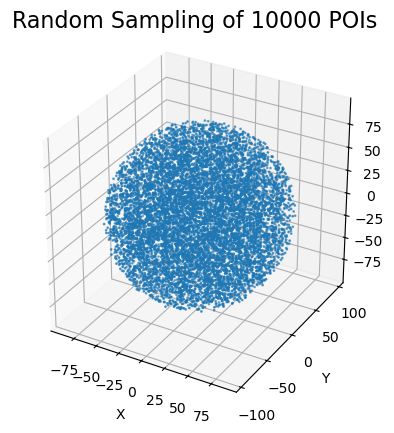

In [2]:
# Seed for reproducibility
np.random.seed(42)

# Ellipsoid radii
x_rad, y_rad, z_rad = 89.25936980982259, 95.71775985586366, 90.29429122218403
a, b, c = x_rad, y_rad, z_rad

# Function to generate a random point inside a unit sphere using rejection sampling
def randompoint(ndim=3):
    while True:
        point = np.random.uniform(-1, 1, size=(ndim,))
        if np.linalg.norm(point) <= 1:
            return point

# Function to scale points from the unit sphere to the ellipsoid
f = lambda x, y, z: np.multiply(np.array([a, b, c]), np.array([x, y, z]))

# Generate points until we have, let's say, 5000 points
n = 10000
points = []
while len(points) < n:
    x, y, z = randompoint()
    scaled_point = f(x, y, z)
    points.append(scaled_point)

# Convert list to numpy array for easier handling
points = np.array(points)

# Plot the generated points
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

# Set aspect ratio for the axes
ax.set_box_aspect((np.ptp(points[:, 0]), np.ptp(points[:, 1]), np.ptp(points[:, 2])))

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Random Sampling of 10000 POIs", fontsize=16)

plt.show()


Now the function is optimized. For this optimization, I decided on 2 spacecrafts in the swarm. To make sure the optimization does not converge to the same states for both spacecrafts, I modeled both spacecrafts in the same objective function by adding them together. Essentially the objective function (the function I'm trying to minimize) became $$\text{objective} = \text{cost}_{spacecraft 1} + \text{cost}_{spacecraft 2}$$


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import scipy
from scipy.optimize import minimize
from scipy.special import erf
from numpy import sqrt
from tqdm import tqdm 
import itertools
from numpy import cos 
from numpy import tan

In [13]:
# Define the objective function to minimize
def objective_function(x):
    init_vals=x
    apex=np.array([0, 0, 0])
    pos = 0
    norm_pos = 0
    total_overlap = 0.0
    tot_vol=0 
    orth_dist=0


    for i in range(3, len(init_vals), 4):
        fov_range = [np.degrees(fov) -  init_vals[i] / 2, np.degrees(fov) + init_vals[i] / 2]
        pos = np.array([init_vals[i - 3], init_vals[i - 2], init_vals[i - 1]]) * 1e2
        mu1, mu2, mu3 = pos[0], pos[1], pos[2]
        origin = pos
        norm_pos = (pos[0]**2 + pos[1]**2 + pos[2]**2)**0.5
        distance= ((origin - apex)[0]**2+(origin - apex)[1]**2+(origin - apex)[2]**2)**0.5
        
        arr = []
        for point in points: 
            vec = origin - apex
            vec_norm= vec/((vec[0]**2+vec[1]**2+vec[2]**2)**0.5)
            cone_dist = np.dot(origin-point, vec_norm)
            cone_radius = (cone_dist / distance) * 50
            orth_distance = (((origin-point)-cone_dist*vec_norm)[0]**2+((origin-point)-cone_dist*vec_norm)[1]**2+((origin-point)-cone_dist*vec_norm)[2]**2)**0.5
            
            # if orth_distance<=cone_radius:
            #     arr.append(point)
            #orth_dist= orth_dist+orth_distance

        for j in range(i + 4, len(init_vals), 4):
            start1, end1 = init_vals[i] - fov / 2, init_vals[i] + fov / 2
            start2, end2 = init_vals[j] - fov / 2, init_vals[j] + fov / 2
            overlap_start = max(start1, start2)
            overlap_end = min(end1, end2)
    
            overlap = max(0, overlap_end-overlap_start)
                
            total_overlap = total_overlap+overlap
                
            if np.abs(init_vals[i] - init_vals[j]) < 0.01:
                if init_vals[j] == 0:
                    init_vals[j] = init_vals[j] + 0.01
                total_overlap = total_overlap + np.cos(init_vals[i] / init_vals[j])
    #mu1, mu2, mu3, mu4, mu5, mu6 = x[:6]

    #the mu1 initial condition of the first SC was scaled by 1e-4 because the x pos. state is an order of 1e4 larger than the y and z positions and 
    #we do not want this to unnecessarily influence the optimization

    cost= -(orth_distance - total_overlap)*(erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 - 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 - 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 - 1)/2) + erf(sqrt(2)*mu1*(mu1 + 1)/2)*erf(sqrt(2)*mu2*(mu2 + 1)/2)*erf(sqrt(2)*mu3*(mu3 + 1)/2))/8
    #cost 1 is the cost for spacecraft 1 and cost 2 is for spacecraft 2
    return cost
 

x = np.array([100, 200, 300, np.pi / 8, 100, 200, 300, np.pi / 8, 100, 200, 300, np.pi / 8])

#all of the variables were left unbounded except for the angles. In the FOV equation, we see that AFOV is bounded by arctan, which has 
#bounds of -90 to 90 degrees. Phi was left as bounded by the standard angle range, 0-360 degrees.
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0, 2 * np.pi)] * 3

result= minimize(objective_function, x, method= "Nelder-Mead", bounds= bounds) #I chose to use the Nelder-Mead method of 
#optimizaition because it is robust to noisy functions, like this one 

print("Optimized distance of SC1", result.x[0], result.x[1], result.x[2])
print("Optimized angles of SC1 in degrees", np.rad2deg(result.x[3]))
print("Optimized distance of SC2", result.x[4], result.x[5], result.x[6])
print("Optimized angles of SC2 in degrees", np.rad2deg(result.x[7]))
print("Optimized distance of SC3", result.x[8], result.x[9], result.x[10])
print("Optimized angles of SC3 in degrees", np.rad2deg(result.x[11]))
print("Objective function value", result.fun)
print(result.x)

KeyboardInterrupt: 

In [14]:
pos_1 = result.x[:3]
pos_2 = result.x[4:7]
pos_3 = result.x[8:11]
#pos_4= result.x[12:15]
#pos_5= result.x[16:19]
#pos_5= result.x[21:24]
#np.degrees(result.x[-1])
angle_1 = np.degrees(np.arccos(pos_1[2] / np.linalg.norm(pos_1)))
angle_2 = np.degrees(np.arccos(pos_2[2] / np.linalg.norm(pos_2)))
angle_3 = np.degrees(np.arccos(pos_3[2] / np.linalg.norm(pos_3)))


NameError: name 'result' is not defined

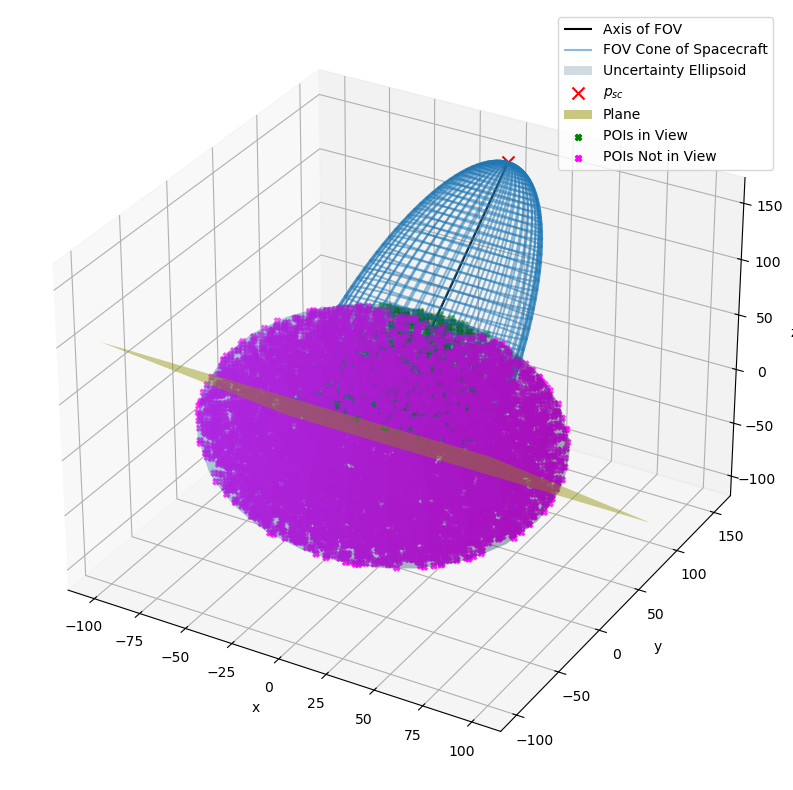

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Function to rotate a vector around a given axis by a given angle
def rotate_vector(vector, axis, angle):
    axis = axis / np.linalg.norm(axis)
    vector = vector * np.cos(angle) + np.cross(axis, vector) * np.sin(angle) + axis * np.dot(axis, vector) * (1 - np.cos(angle))
    return vector

# the field of view (FOV)
fov = np.pi / 4

pos_1 = np.array([0, 150, 150])
# Define the position of the apex of the cone (green X)
origin = np.array([pos_1[0], pos_1[1], pos_1[2]])

# Define the origin
apex = np.array([0, 0, 0])

# Create a figure
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Generate mesh grid for the cone
u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi/2:80j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)  # Pointy part towards the z direction

distance = np.linalg.norm(origin - apex)

# Scale the cone to make it bigger
scale_factor = 100  # Adjust this scale factor as needed
x *= 50
y *= 50
z *= distance

half_ang = np.arctan(50 / distance)

# Translate the cone to have its apex at the specified position
x += apex[0]
y += apex[1]
z += apex[2]

# Calculate the direction vector from the apex to the origin
direction_vector = origin - apex
vec = origin - apex
direction_vector = direction_vector / np.linalg.norm(direction_vector)

# Calculate the axis and angle of rotation to align the cone's axis with the direction vector
axis_of_rotation = np.cross([0, 0, 1], direction_vector)
angle_of_rotation = np.arccos(np.dot([0, 0, 1], direction_vector))

# Apply rotation to the cone points
for i in range(len(x)):
    for j in range(len(x[i])):
        vec = np.array([x[i][j], y[i][j], z[i][j]])
        vec -= apex  # Translate to the origin
        if np.linalg.norm(axis_of_rotation) != 0:
            rotated_vec = rotate_vector(vec, axis_of_rotation, angle_of_rotation)
        else:
            rotated_vec = vec  # No rotation needed if the axis is zero
        rotated_vec += apex  # Translate back
        x[i][j], y[i][j], z[i][j] = rotated_vec

# Plot the direction vector
arrow_length = scale_factor * 0.5  # Adjust this to ensure the arrow is visible
ax.quiver(origin[0], origin[1], origin[2], 
          -direction_vector[0] * distance, -direction_vector[1] * distance, -direction_vector[2] * distance, 
          color='black', label='Axis of FOV',  arrow_length_ratio=0.1)

# Plot the FOV cone
ax.plot_wireframe(x, y, z, cmap=cm.coolwarm, alpha=0.5, label="FOV Cone of Spacecraft")

# Plot the sphere
r = 0.05
u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]

x_sphere = x_rad * np.cos(u) * np.sin(v)
y_sphere = y_rad * np.sin(u) * np.sin(v)
z_sphere = z_rad * np.cos(v)
ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.2, label = "Uncertainty Ellipsoid")

ax.scatter(origin[0], origin[1], origin[2], color="red", label="$p_{sc}$", s=75, marker="x")

# Add axes
axes_rad = 20
ax.quiver(0, 0, 0, axes_rad, 0, 0, color='r')
ax.quiver(0, 0, 0, 0, axes_rad, 0, color='g')
ax.quiver(0, 0, 0, 0, 0, axes_rad, color='b')

ax.quiver(apex[0], apex[1], apex[2], direction_vector[0], direction_vector[1], direction_vector[2])

xx, yy = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))

d = np.dot(direction_vector, apex)
zz = (d - direction_vector[0] * xx - direction_vector[1] * yy) / direction_vector[2]

ax.plot_surface(xx, yy, zz, color='yellow', alpha=0.5, label="Plane")
obs_POIs = []
non_obs = []
for point in points: 
    vec = origin - apex
    vec_norm = vec / np.linalg.norm(vec)
    cone_dist = np.dot(origin - point, vec_norm)
    cone_radius = (cone_dist / distance) * 50
    orth_distance = np.linalg.norm((origin - point) - cone_dist * vec_norm)
    valid = np.dot(point, origin)
    if orth_distance <= cone_radius and (valid > 0):
        obs_POIs.append(point)
    else:
        non_obs.append(point)
non_obs = np.array(non_obs)
obs_POIs = np.array(obs_POIs)
ax.scatter(obs_POIs[:,0], obs_POIs[:,1], obs_POIs[:,2], color= 'green', marker= 'X', label="POIs in View")
ax.scatter(non_obs[:,0], non_obs[:,1], non_obs[:,2], color= 'magenta', marker= 'X', label="POIs Not in View")

# Set labels and view
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
#ax.legend()

# Show the plot
plt.legend()
plt.show()


[]

In [42]:
# # Define the position of the apex of the cone (green X)
# origin = np.array([pos_2[0], pos_2[1], pos_2[2]])

# # Define the origin
# apex = np.array([0, 0, 0])


# # Generate mesh grid for the cone
# u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi/2:80j]
# x = np.cos(u) * np.sin(v)
# y = np.sin(u) * np.sin(v)
# z = np.cos(v)  # Pointy part towards the z direction

# distance = np.linalg.norm(origin - apex)

# # Scale the cone to make it bigger
# scale_factor = 100  # Adjust this scale factor as needed
# x *= 50
# y *= 50
# z *= distance

# half_ang=np.arctan(50/distance)

# # Translate the cone to have its apex at the specified position
# x += apex[0]
# y += apex[1]
# z += apex[2]

# # Calculate the direction vector from the apex to the origin
# direction_vector = origin - apex
# direction_vector = direction_vector / np.linalg.norm(direction_vector)

# # Calculate the axis and angle of rotation to align the cone's axis with the direction vector
# axis_of_rotation = np.cross([0, 0, 1], direction_vector)
# angle_of_rotation = np.arccos(np.dot([0, 0, 1], direction_vector))

# # Apply rotation to the cone points
# for i in range(len(x)):
#     for j in range(len(x[i])):
#         vec = np.array([x[i][j], y[i][j], z[i][j]])
#         vec -= apex  # Translate to the origin
#         if np.linalg.norm(axis_of_rotation) != 0:
#             rotated_vec = rotate_vector(vec, axis_of_rotation, angle_of_rotation)
#         else:
#             rotated_vec = vec  # No rotation needed if the axis is zero
#         rotated_vec += apex  # Translate back
#         x[i][j], y[i][j], z[i][j] = rotated_vec

# # Plot the direction vector
# arrow_length = scale_factor * 0.5  # Adjust this to ensure the arrow is visible
# ax.quiver(apex[0], apex[1], apex[2], 
#           direction_vector[0]*arrow_length, direction_vector[1]*arrow_length, direction_vector[2]*arrow_length, 
#           color='r', label='Viewing Direction')

# # Plot the FOV cone
# ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.7)

# for point in points: 
#     vec = origin - apex
#     vec_norm= vec/np.linalg.norm(vec)
#     cone_dist = np.dot(origin - point, vec_norm)
#     cone_radius = (cone_dist / distance) * 50
#     orth_distance = np.linalg.norm((origin - point) - cone_dist * vec_norm)
#     if orth_distance <= cone_radius:
#         ax.plot(point[0], point[1], point[2], color= 'blue', marker= 'X')

# # Define the position of the apex of the cone (green X)
# origin = np.array([pos_3[0], pos_3[1], pos_3[2]])

# # Define the origin
# apex = np.array([0, 0, 0])


# # Generate mesh grid for the cone
# u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi/2:80j]
# x = np.cos(u) * np.sin(v)
# y = np.sin(u) * np.sin(v)
# z = np.cos(v)  # Pointy part towards the z direction

# distance = np.linalg.norm(origin - apex)

# # Scale the cone to make it bigger
# scale_factor = 100  # Adjust this scale factor as needed
# x *= 50
# y *= 50
# z *= distance

# half_ang=np.arctan(50/distance)

# # Translate the cone to have its apex at the specified position
# x += apex[0]
# y += apex[1]
# z += apex[2]

# # Calculate the direction vector from the apex to the origin
# direction_vector = origin - apex
# direction_vector = direction_vector / np.linalg.norm(direction_vector)

# # Calculate the axis and angle of rotation to align the cone's axis with the direction vector
# axis_of_rotation = np.cross([0, 0, 1], direction_vector)
# angle_of_rotation = np.arccos(np.dot([0, 0, 1], direction_vector))

# # Apply rotation to the cone points
# for i in range(len(x)):
#     for j in range(len(x[i])):
#         vec = np.array([x[i][j], y[i][j], z[i][j]])
#         vec -= apex  # Translate to the origin
#         if np.linalg.norm(axis_of_rotation) != 0:
#             rotated_vec = rotate_vector(vec, axis_of_rotation, angle_of_rotation)
#         else:
#             rotated_vec = vec  # No rotation needed if the axis is zero
#         rotated_vec += apex  # Translate back
#         x[i][j], y[i][j], z[i][j] = rotated_vec

# # Plot the direction vector
# arrow_length = scale_factor * 0.5  # Adjust this to ensure the arrow is visible
# ax.quiver(apex[0], apex[1], apex[2], 
#           direction_vector[0]*arrow_length, direction_vector[1]*arrow_length, direction_vector[2]*arrow_length, 
#           color='r', label='Viewing Direction')

# # Plot the FOV cone
# ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.7)

# for point in points: 
#     vec = origin - apex
#     vec_norm= vec/np.linalg.norm(vec)
#     cone_dist = np.dot(origin-point, vec_norm)
#     cone_radius = (cone_dist / distance) * 50
#     orth_distance = np.linalg.norm((origin-point)-cone_dist*vec_norm)
#     if orth_distance<=cone_radius:
#         ax.plot(point[0], point[1], point[2], color= 'red', marker= 'X')




# # Define the position of the apex of the cone (green X)
# origin = np.array([pos_4[0], pos_4[1], pos_4[2]])

# # Define the origin
# apex = np.array([0, 0, 0])


# # Generate mesh grid for the cone
# u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi/2:80j]
# x = np.cos(u) * np.sin(v)
# y = np.sin(u) * np.sin(v)
# z = np.cos(v)  # Pointy part towards the z direction

# distance = np.linalg.norm(origin - apex)

# # Scale the cone to make it bigger
# scale_factor = 100  # Adjust this scale factor as needed
# x *= 50
# y *= 50
# z *= distance

# half_ang=np.arctan(50/distance)

# # Translate the cone to have its apex at the specified position
# x += apex[0]
# y += apex[1]
# z += apex[2]

# # Calculate the direction vector from the apex to the origin
# direction_vector = origin - apex
# direction_vector = direction_vector / np.linalg.norm(direction_vector)

# # Calculate the axis and angle of rotation to align the cone's axis with the direction vector
# axis_of_rotation = np.cross([0, 0, 1], direction_vector)
# angle_of_rotation = np.arccos(np.dot([0, 0, 1], direction_vector))

# # Apply rotation to the cone points
# for i in range(len(x)):
#     for j in range(len(x[i])):
#         vec = np.array([x[i][j], y[i][j], z[i][j]])
#         vec -= apex  # Translate to the origin
#         if np.linalg.norm(axis_of_rotation) != 0:
#             rotated_vec = rotate_vector(vec, axis_of_rotation, angle_of_rotation)
#         else:
#             rotated_vec = vec  # No rotation needed if the axis is zero
#         rotated_vec += apex  # Translate back
#         x[i][j], y[i][j], z[i][j] = rotated_vec

# # Plot the direction vector
# arrow_length = scale_factor * 0.5  # Adjust this to ensure the arrow is visible
# ax.quiver(apex[0], apex[1], apex[2], 
#           direction_vector[0]*arrow_length, direction_vector[1]*arrow_length, direction_vector[2]*arrow_length, 
#           color='r', label='Viewing Direction')

# # Plot the FOV cone
# #ax.plot_surface(x, y, z, cmap=cm.coolwarm, alpha=0.7)

# for point in points: 
#     vec = origin - apex
#     vec_norm= vec/np.linalg.norm(vec)
#     cone_dist = np.dot(origin-point, vec_norm)
#     cone_radius = (cone_dist / distance) * 50
#     orth_distance = np.linalg.norm((origin-point)-cone_dist*vec_norm)
#     if orth_distance<=cone_radius:
#         ax.plot(point[0], point[1], point[2], color= 'yellow', marker= 'X')


